In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
from astropy.io import fits
from astropy.stats import LombScargle
import healpy
from healpy.sphtfunc import Alm
import pystan

In [42]:
model = pystan.StanModel(file='emission_map.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_abe1c4b84efee1267ff862c197b0be86 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp6nrb12gu/stanfit4anon_model_abe1c4b84efee1267ff862c197b0be86_6855385020276908184.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [4]:
with fits.open('maia_k2sc.fits', 'readonly') as f:
    ts = f[1].data['time']
    flux = f[1].data['flux']
    flux_error = f[1].data['error']

<ErrorbarContainer object of 3 artists>

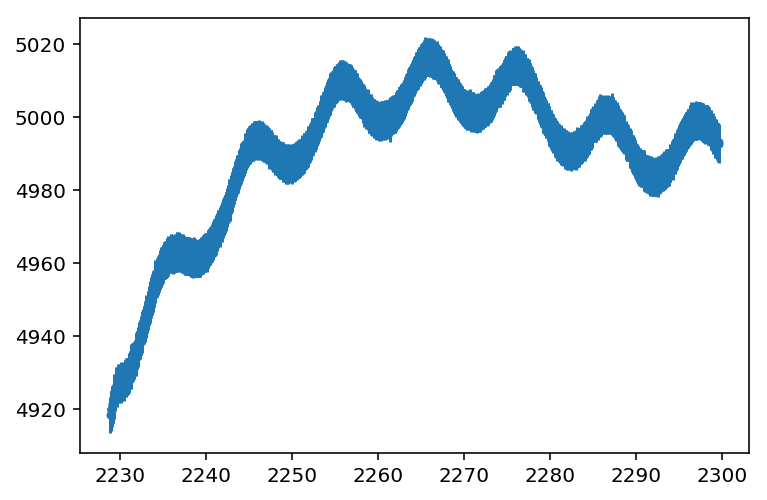

In [5]:
errorbar(ts, flux, flux_error, fmt='.')

We are *way* over-sampled to extract the $\sim 10 \, \mathrm{d}$ signal in this lightcurve.  Let's do a moving average with a timescale of 1 day.

<ErrorbarContainer object of 3 artists>

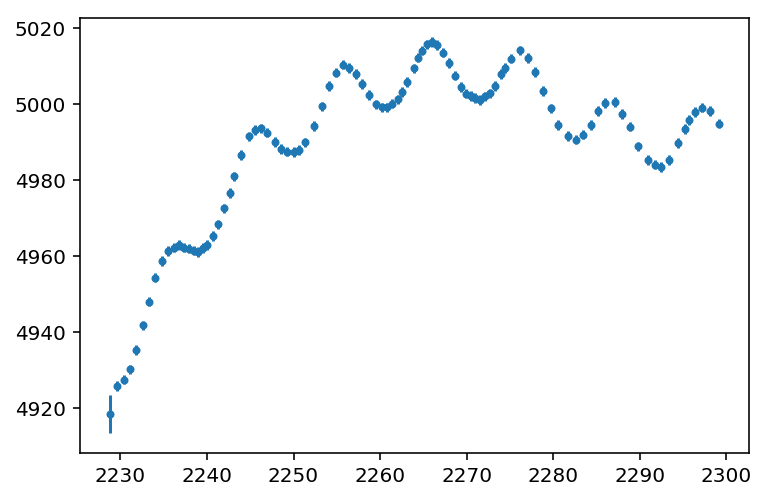

In [6]:
ma_flux = [flux[0]]
ma_flux_error = [flux_error[0]]
for i in range(1, len(ts)):
    dt = ts[i] - ts[i-1]
    wt = exp(-dt)
    
    wt0 = 1.0/(1.0 + wt)
    wt1 = wt/(1.0 + wt)
    
    ma_flux.append(wt0*flux[i] + wt1*ma_flux[-1])
    ma_flux_error.append(sqrt(wt0*wt0*flux_error[i] + wt1*wt1*ma_flux_error[-1]))
ma_flux = array(ma_flux)
ma_flux_error = array(ma_flux_error)

dec_factor = int(round(1/diff(ts)[0]))
ts_ma = ts[::dec_factor]
ma_flux = ma_flux[::dec_factor]
ma_flux_error = ma_flux_error[::dec_factor]

errorbar(ts_ma, ma_flux, ma_flux_error, fmt='.')

It will be convenient to standardize the lightcurve:

<ErrorbarContainer object of 3 artists>

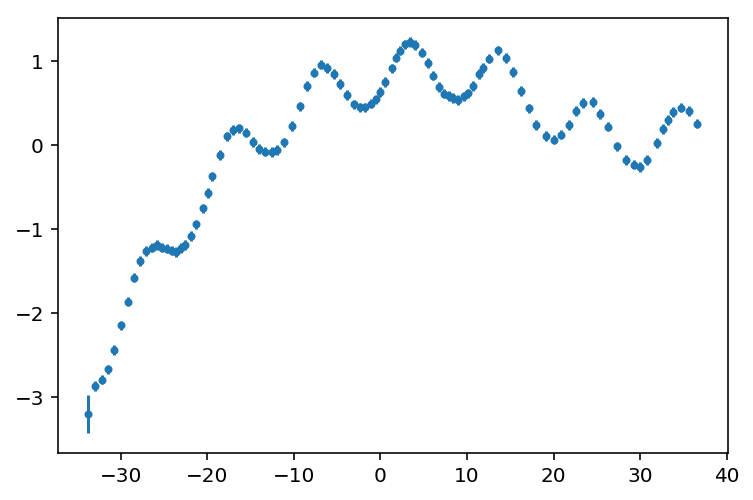

In [7]:
mu = mean(ma_flux)
sigma = std(ma_flux)

ma_flux = (ma_flux-mu)/sigma
ma_flux_error = ma_flux_error/sigma

ts_ma = ts_ma-median(ts_ma)

errorbar(ts_ma, ma_flux, ma_flux_error, fmt='.')

Let's look at the frequency content of the lightcurve:

In [8]:
f, p = LombScargle(ts_ma, ma_flux, ma_flux_error).autopower()

That peak near $1/10 \, \mathrm{d}^{-1}$ is the one we want:

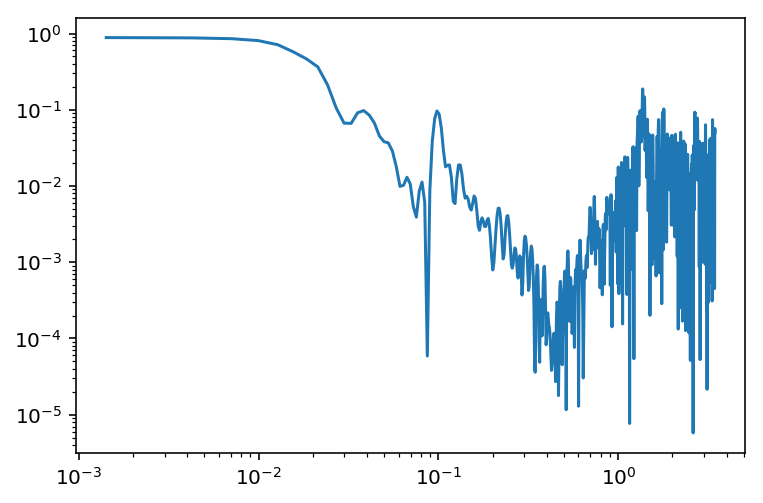

In [9]:
loglog(f, p)

Here we fit for the period and the uncertainty in the period from the L-S periodogram peak:

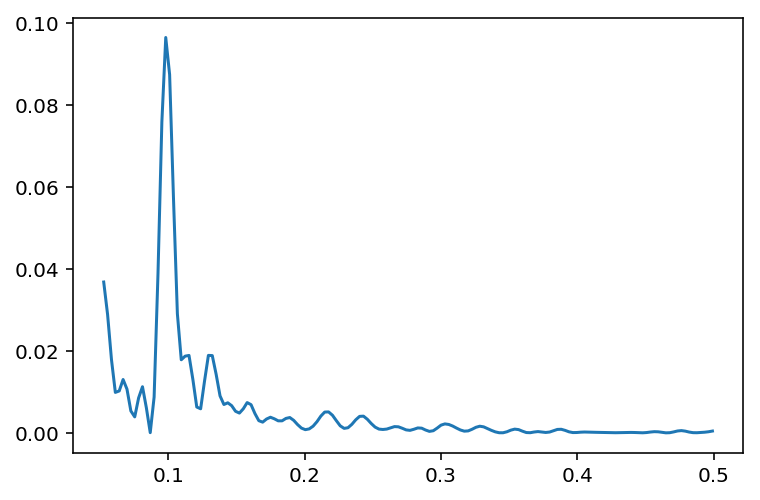

In [10]:
s = (0.05 < f) & (f < 0.5)
plot(f[s], p[s])

In [11]:
im = argmax(p[s])
f0 = f[s][im-1]
f1 = f[s][im]
f2 = f[s][im+1]

p0 = p[s][im-1]
p1 = p[s][im]
p2 = p[s][im+1]

fbest = (f2**2*(p0-p1) + f0**2*(p1-p2) + f1**2*(p2-p0))/(2.0*(f2*(p0-p1) + f0*(p1-p2) + f1*(p2-p0)))
sigma_f = sqrt(-(f2-f0)/(2.0*((p1-p0)/(f0-f1) + (p1-p2)/(f1-f2))))

pbest = 1.0/fbest
sigma_p = 1.0/fbest**2*sigma_f

(pbest, sigma_p)

(10.135012335155157, 1.6965045688593943)

Clearly there is a lot of power at low scales; we need to fit that out.  Here we will use a low-order polynomial fit.  We generate the design matrix for the fit, and then SVD it to get an orthogonal basis of lightcurves with which to do the fitting:

In [12]:
t0 = median(ts_ma)
M = column_stack((ones_like(ts_ma), (ts_ma-t0), (ts_ma-t0)**2, (ts_ma-t0)**3, (ts_ma-t0)**4))
u, s, v = linalg.svd(M, full_matrices=False)

# Normalize to max() == 1
for j in range(u.shape[1]):
    u[:,j] /= np.max(np.abs(u[:,j]))

Here are the orthogonal basis components:

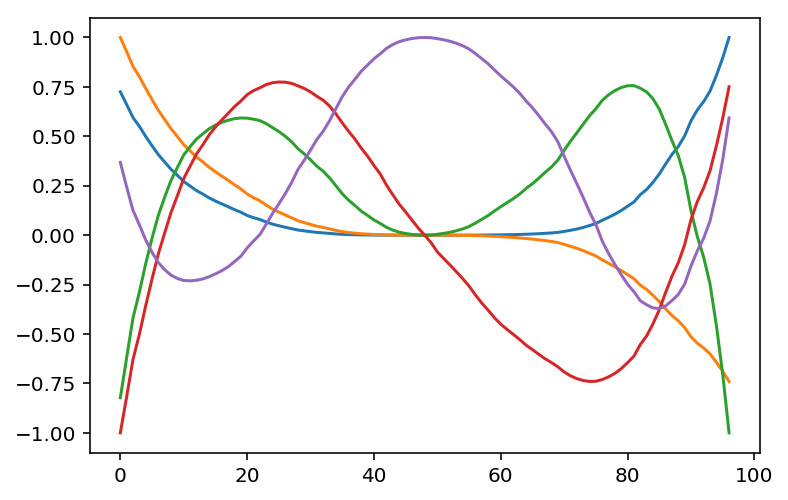

In [13]:
for j in range(u.shape[1]):
    plot(u[:,j])

We need to generate the matrix that transforms the $a_{lm}$ basis to pixels.  We use healpix to do that.

In [14]:
lmax = 3
nside = 2 # Over-resolved with l = 3
Ylm_matrix = []
ls = []
for l in range(lmax+1):
    for m in range(0, l+1):
        alm_array = zeros(Alm.getsize(lmax), dtype=np.complex)
        alm_array[Alm.getidx(lmax, l, m)] = 1.0
        Ylm_matrix.append(healpy.alm2map(alm_array, nside))
        ls.append(l)
        if m > 0:
            alm_array[Alm.getidx(lmax, l, m)] = 1.0j
            Ylm_matrix.append(healpy.alm2map(alm_array, nside))
            ls.append(l)
Ylm_matrix = array(Ylm_matrix).T
ls = array(ls, dtype=np.int)

# We drop the l = 0, m = 0 component because it is degenerate with the trend components.
Ylm_matrix = Ylm_matrix[:, 1:]
ls = ls[1:]

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

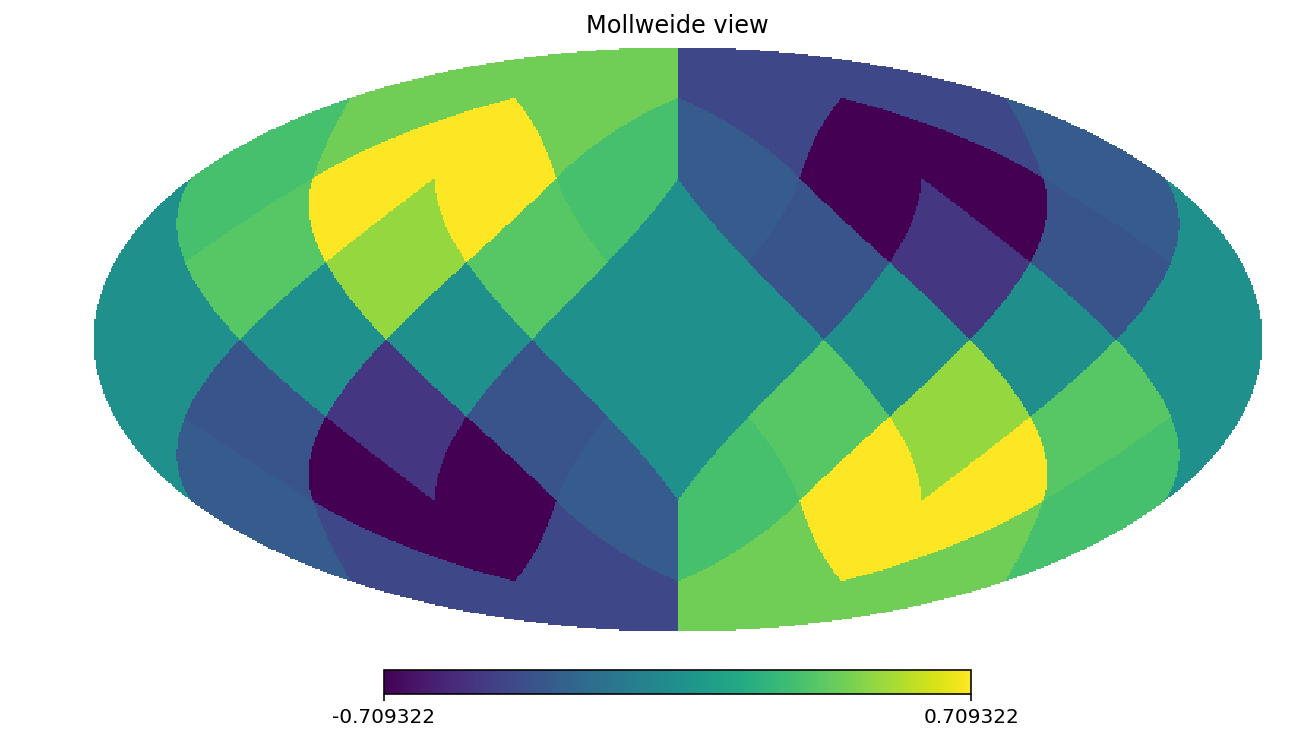

In [15]:
healpy.mollview(Ylm_matrix[:,5])

We are over-sampled relative to the $Y_{lm}$ basis, which is good:

In [16]:
Ylm_matrix.shape

(48, 15)

The pattern is from $m=0$ to $m=l$, alternating positive and negative $m$, before incrementing $l$.

In [17]:
ls

array([1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3])

The final thing we need is the pixel vectors.

In [18]:
pix_nhat = []
for i in range(healpy.nside2npix(nside)):
    pix_nhat.append(healpy.pix2vec(nside, i))
pix_nhat = array(pix_nhat)

In [56]:
data = {
    'lmax': lmax,
    'nalm': Ylm_matrix.shape[1],
    'npix': Ylm_matrix.shape[0],
    'ntrend': u.shape[1],
    
    'nobs': len(ts_ma),
    
    'l_alm': ls,
    
    'sht_matrix': Ylm_matrix,
    
    'pix_nhat': pix_nhat,
    
    'time': ts_ma, # zero phase happens at middle of array
    'flux': ma_flux,
    'sigma_flux': ma_flux_error,
    
    'trend_basis': u,
    
    'Pmin': pbest - 5.0*sigma_p,
    'Pmax': pbest + 5.0*sigma_p,
    'cos_iota_min': 0.0,
    'cos_iota_max': 1.0
}

In [57]:
d = data.copy()
d['Pmin'] = pbest - 1e-3
d['Pmax'] = pbest + 1e-3
d['cos_iota_min'] = 0.0
d['cos_iota_max'] = 0.01
p = model.optimizing(data=d, iter=10000)

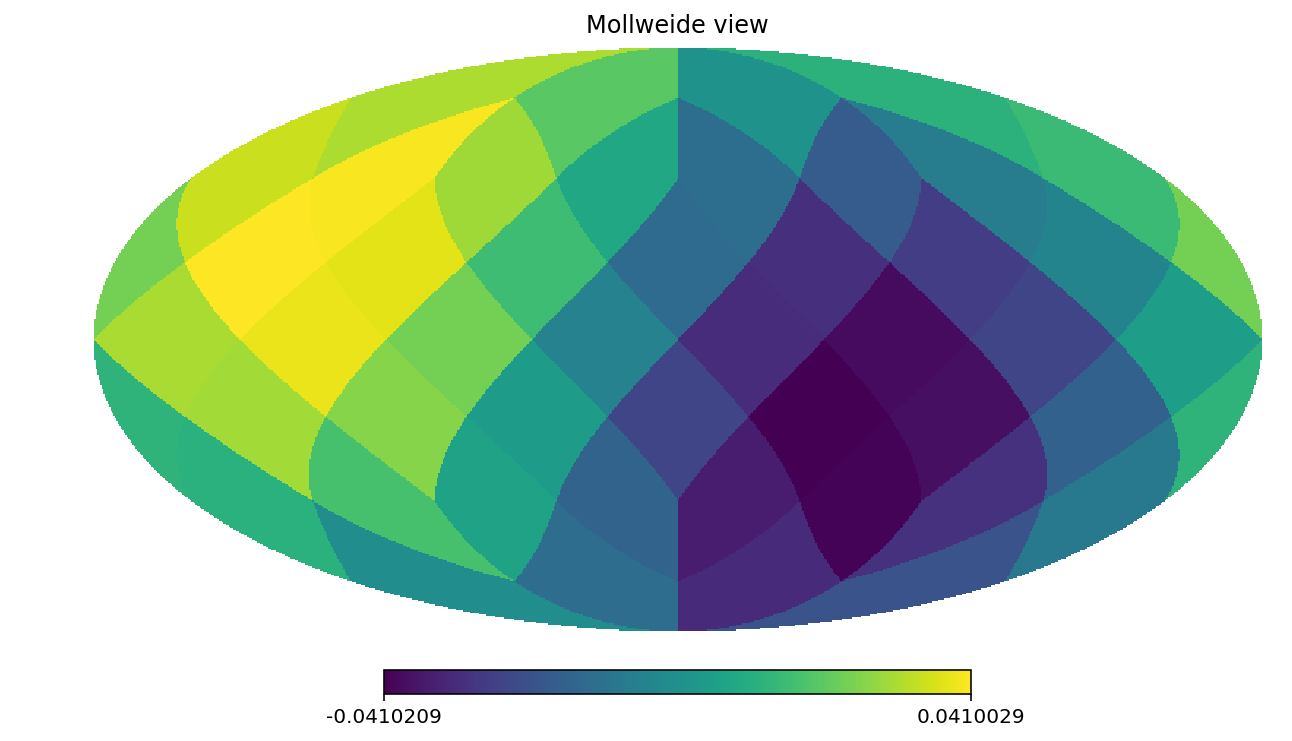

In [58]:
healpy.mollview(p['pix_map'])

<ErrorbarContainer object of 3 artists>

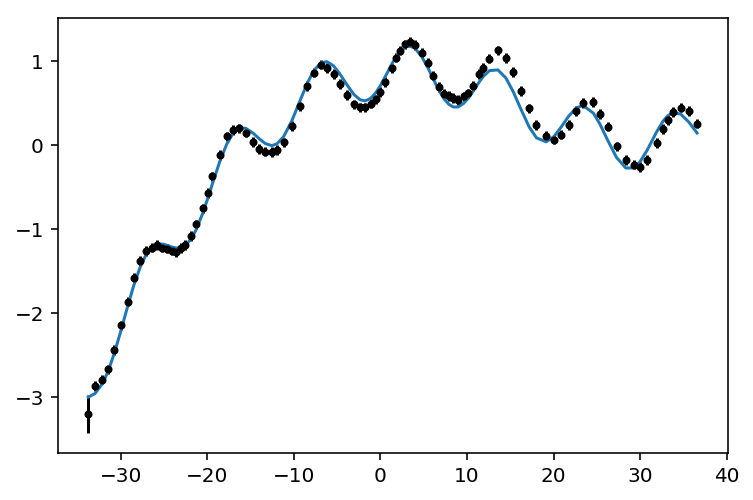

In [59]:
plot(ts_ma, p['lightcurve'])
errorbar(ts_ma, ma_flux, ma_flux_error, fmt='.', color='k')

In [60]:
p['cos_iota'], p['P']

(array(0.00170813), array(10.13561736))

In [ ]:
fit = model.sampling(data=data, init=(p,)*4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c242bdcc0>,
      dtype=object)

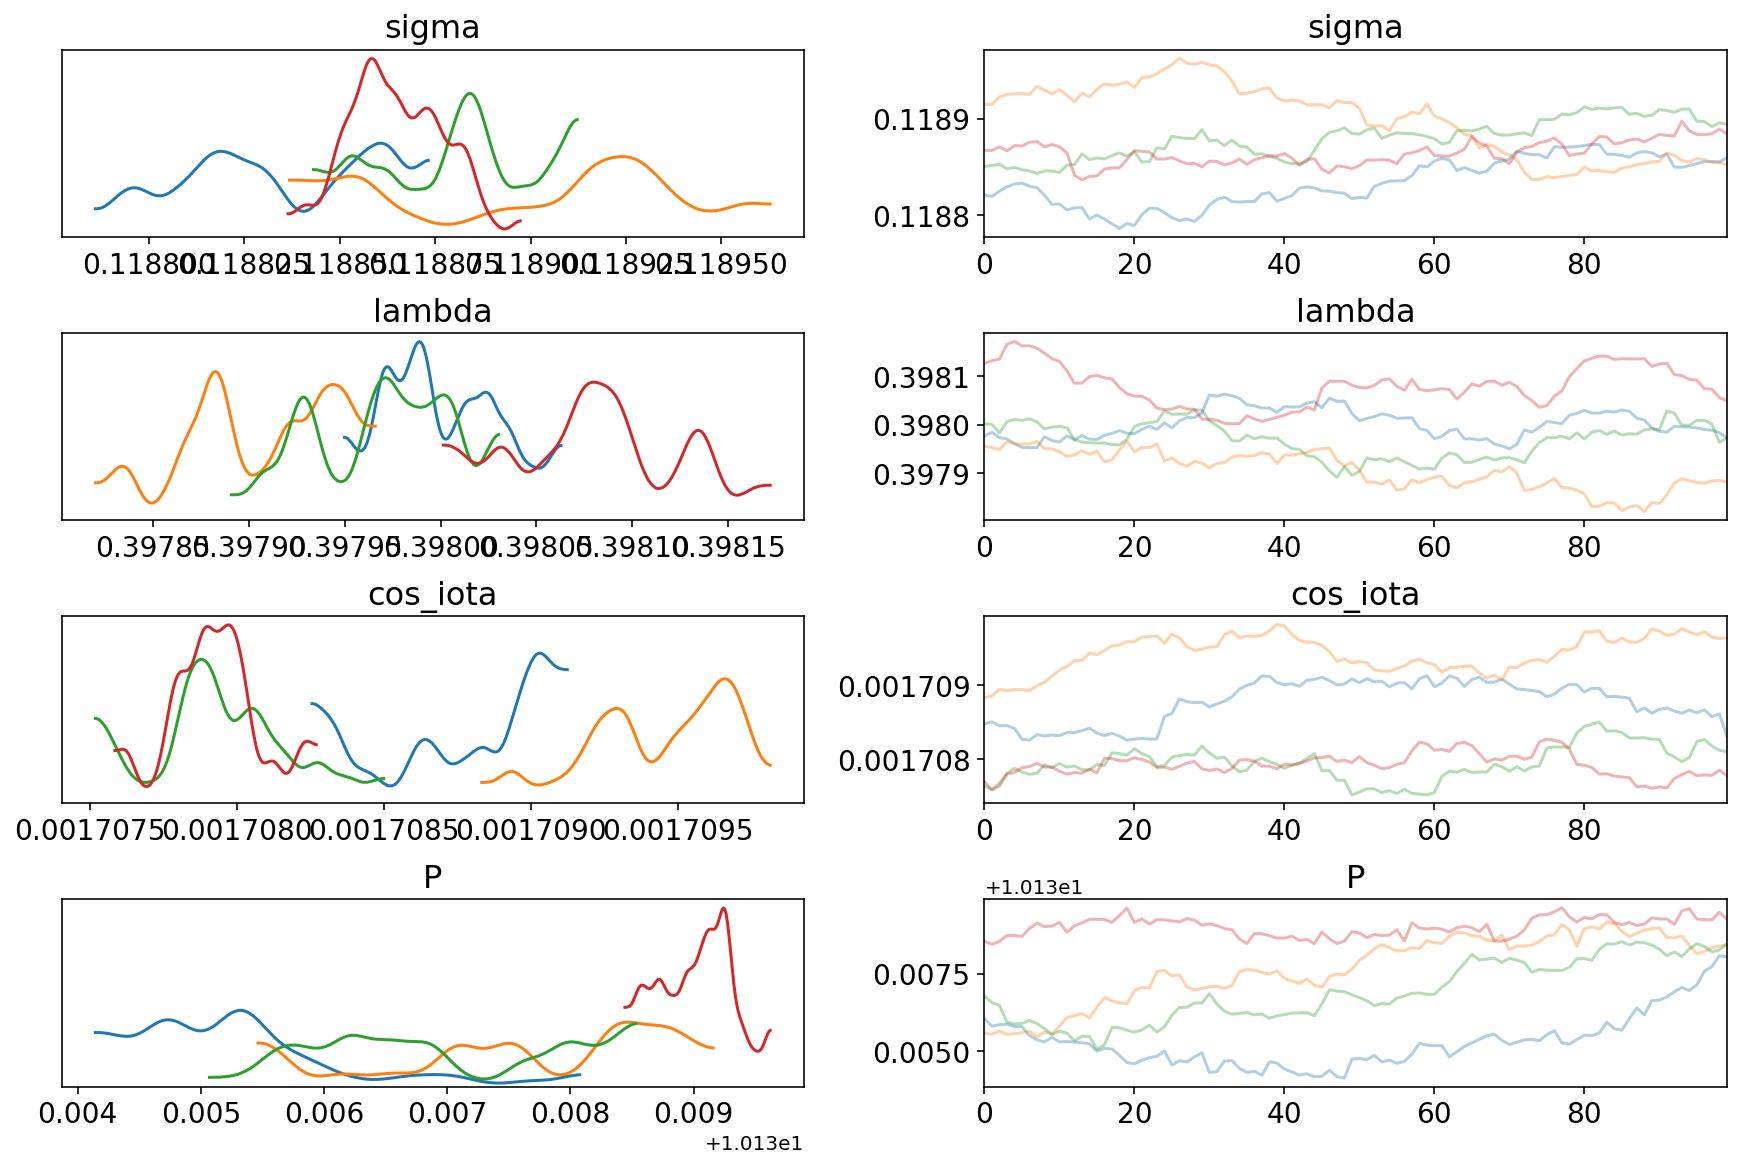

In [62]:
az.plot_trace(fit, var_names=['sigma', 'lambda', 'cos_iota', 'P'])

In [63]:
chain = fit.extract(permuted=True)

<ErrorbarContainer object of 3 artists>

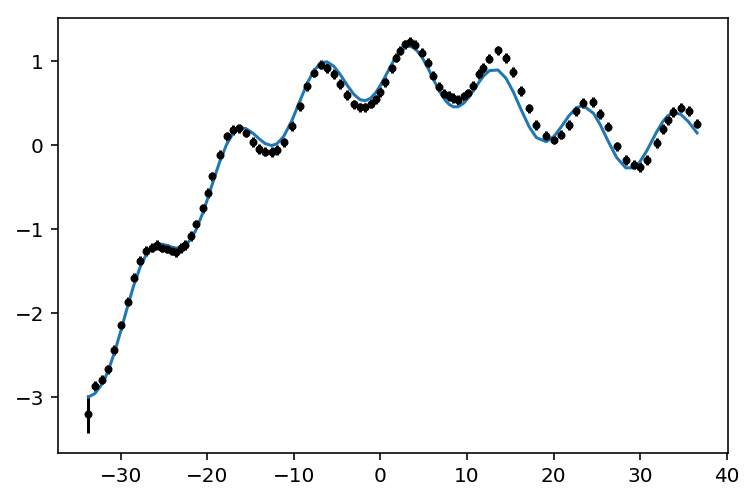

In [64]:
plot(ts_ma, mean(chain['lightcurve'], axis=0))
errorbar(ts_ma, ma_flux, ma_flux_error, fmt='.', color='k')

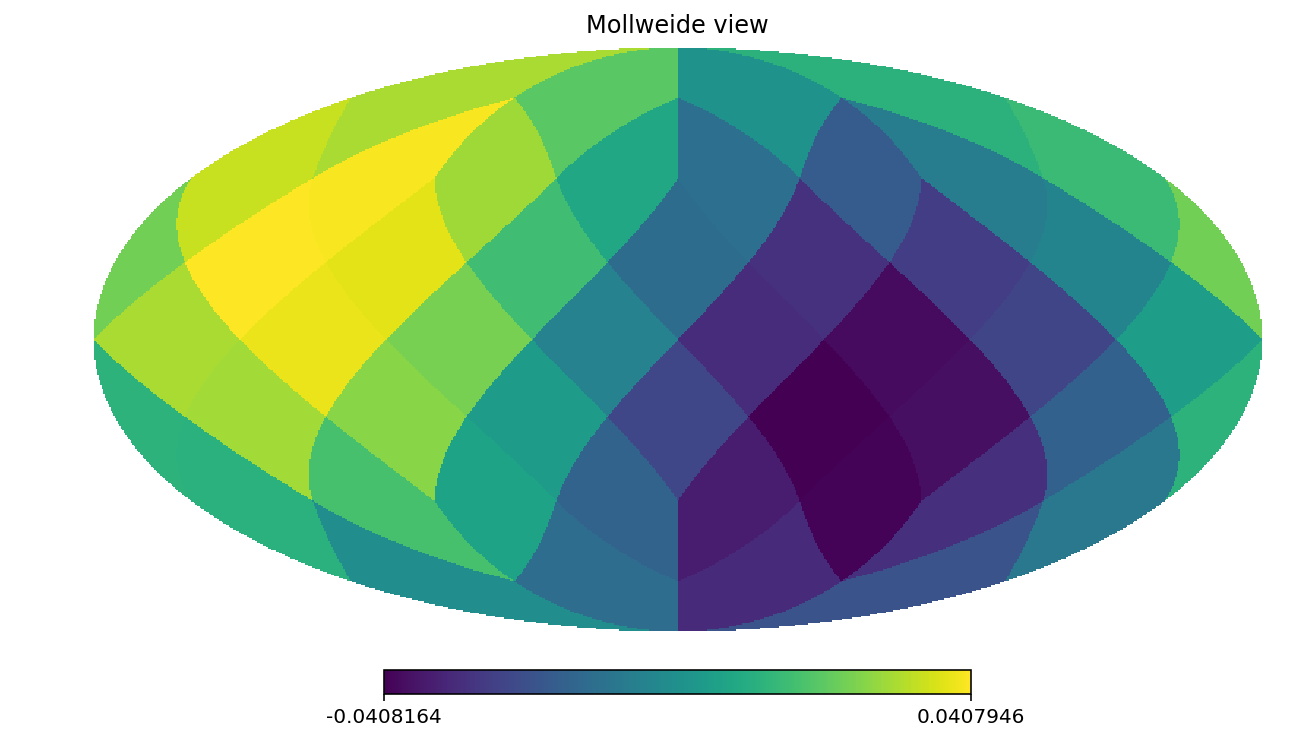

In [65]:
healpy.mollview(mean(chain['pix_map'], axis=0))

[array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a01fd0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a01fd0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a01fd0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a01fd0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a01fd0>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a01fd0>,
       dtype=object)]

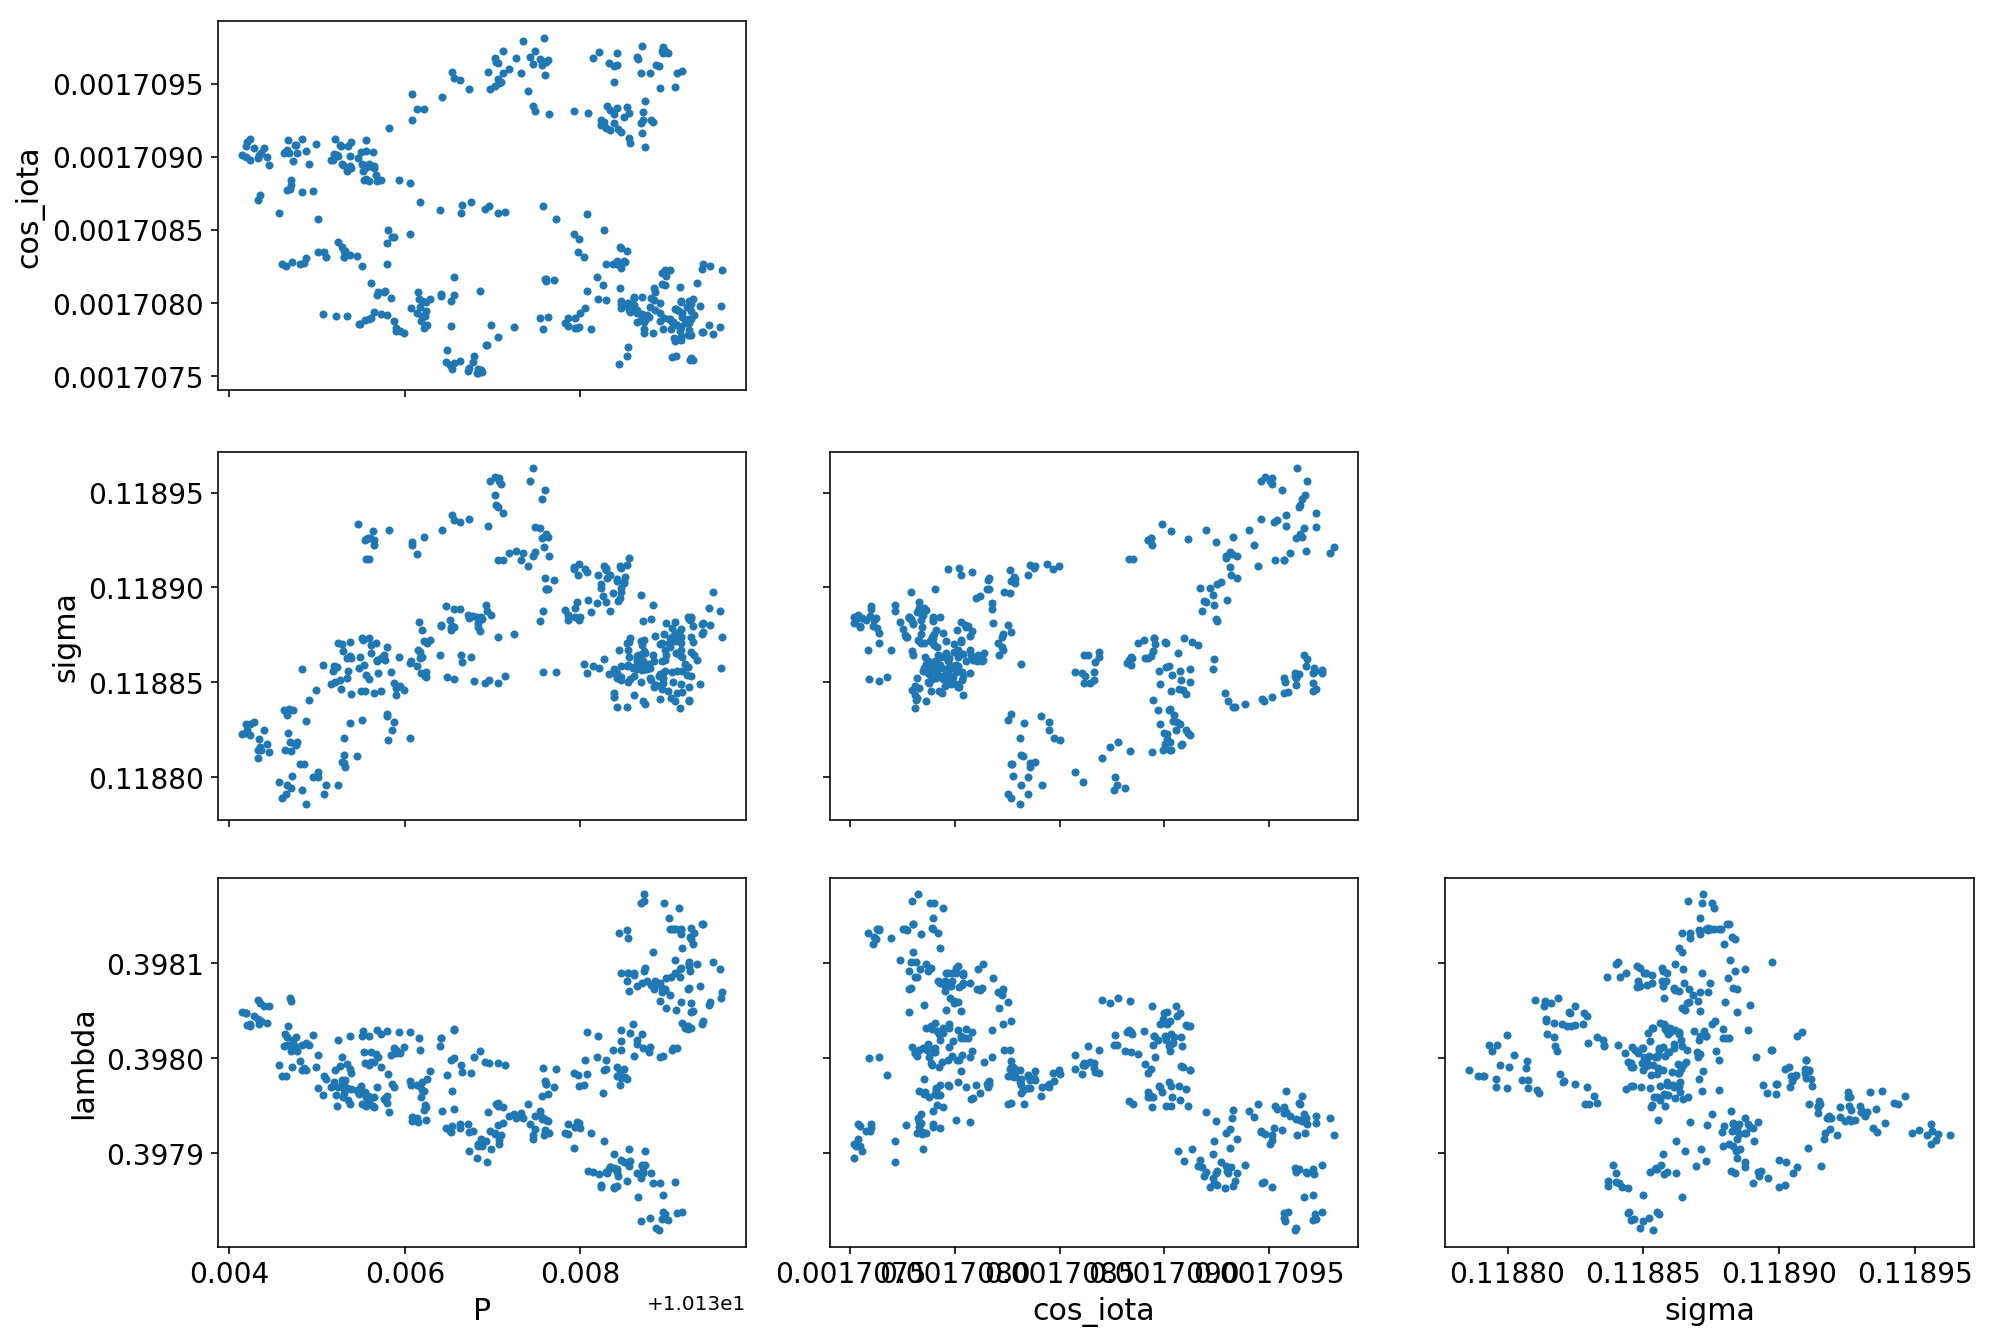

In [66]:
az.plot_pair(fit, var_names=['P', 'cos_iota', 'sigma', 'lambda'])